In [1]:
import numpy as np 
from PIL import Image
import requests
import torch

In [2]:
from transformers import ViTModel, ViTImageProcessor

In [3]:
## load the pre-trained ViT-model (86 Mil)
model_name = 'google/vit-base-patch16-224'

# 
image_processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")
# 86 million model

Trainable parameters: 86,389,248


In [5]:
model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [6]:
# Send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.eval()

In [7]:
model.encoder.layer[0].attention.attention.query.in_features


768

In [8]:
for layer_i, block_i in enumerate(model.encoder.layer):
    print("block_i.attention.attention.query:",block_i.attention.attention.query)
    print("block_i.attention.attention.value:",block_i.attention.attention.value)
    break


block_i.attention.attention.query: Linear(in_features=768, out_features=768, bias=True)
block_i.attention.attention.value: Linear(in_features=768, out_features=768, bias=True)


This is the architecture of the vit model
```
model.encoder.layer[0]
└── attention
    └── attention
        ├── query: nn.Linear
        ├── key:   nn.Linear
        └── value: nn.Linear
```

# Things to do:


## Stage 0. We need to come up with some framework of the project and what exactly are we going to do

## Stage 1. Set up a Transformer based segmentation model using ViT+LoRA
0. Understand and play around with the models
1. Load the pre-trained model
    1.If required, we might have to switch to timm
2. Define the class for LoRA:
    2.1: Either can be set up using `peft` library
    2.2: Build a custom LoRA module using Pytorch.
3. Apply LoRA to attention layers
4. Define (code) and add a segmentation head
    1. Simple MLP or some more complicated architecture? We need to look into it.
5. Training Set-Up
    5.1. Loss for the segmentation task
    5.2 optimizer
6. Training:
    6.1 typical LoRA rank (r): 4 or 8 -  a good balance for fine tuning
    6.2 How many parameters to freeze

Obtain some simple acceptable results for this. 

## Stage 2. Try  1 more different versions of LoRA for the same task:
0. Serial LoRA for the ViT (recent paper)
1. Other  DoRA, etc. (check that review paper for other version)

## Stage 3: Try 1 other different fine tuning strategy, maybe some other adapter based approach/ IA3 etc. 




# LoRA implementation

In [9]:
import torch.nn as nn
import torch
from torch import Tensor
import math
from safetensors.torch import save_file, load_file

In [10]:
### implement the LoRAlayer
class LoraLayer(nn.Module):
    """
    This class implements the LoRA layer
    wt_linear: Weight (which would be left frozen)
    A,B: Lower matrices which constitute delta W
    rank_lora: Rank of A and B matrices
    alpha: some weighing factor
    """
    def __init__(self, wt: nn.Module, A: nn.Module, B: nn.Module, rank_lora: int, alpha: int):
        super().__init__()
        self.wt = wt
        self.A, self.B = A, B
        self.rank = rank_lora
        self.alpha = alpha

    def forward(self,x):

        x=self.wt(x) + (self.alpha / self.rank) * self.B(self.A(x))
        return x

In [11]:
## implement the LoRA VIT
### ? Things to check ?
## ? vit_model.transformer.blocks --> replaced with model.encoder.layer
## ? block.attn.proj_q/p ---> replace with block.attention.attention.query/value.
## ? vit_model.parameters() <--> Stays the same

class LoraVit(nn.Module):
    """ 
    This class is to introduce LoRA layer to the model.
    vit_model: pre-trained vit model
    r: rank
    alpha: scaling strength for lora
    lora_layers: Layers we want to apply lora to
    """
    def __init__(self, vit_model, r:int, alpha:int, lora_layers=None):
        super().__init__()

        assert r>0, "r (rank of lora matrices) must be >0"
        assert alpha>0 , "alpha >0"

        if lora_layers:
            self.lora_layers = lora_layers
        else: ## apply lora to all
            ## ? here I need to see how will I check the number of transformer blocks
            self.lora_layers = list(range(len(vit_model.encoder.layer)))
        
        # Dimension of the input vector to the transformer
        dim = vit_model.encoder.layer[0].attention.attention.query.in_features 
        print(f"dim is: {dim}")
        
        # freeze the parameters
        ## ? How can we invoke paramters in the vit_model
        for param in vit_model.parameters():
            param.requires_grad = False
        
        ## for storing the lora parameters
        self.list_q_As, self.list_q_Bs = [], []
        self.list_v_As, self.list_v_Bs = [], []

        # replace the normal q and V with LoRA layers
        for layer_i, block_i in enumerate(vit_model.encoder.layer):
            if layer_i not in self.lora_layers:
                continue # (next iteration)
            w_q_linear = block_i.attention.attention.query
            w_v_linear = block_i.attention.attention.value
            # Q and V layers' weights

            ## do I need to initialise weights here? or should I do it after this loop?
            a_linear_q = nn.Linear(dim, r, bias=False)
            b_linear_q = nn.Linear(r, dim, bias=False)
            a_linear_v = nn.Linear(dim, r, bias=False)
            b_linear_v = nn.Linear(r, dim, bias=False)

            # Append lora params to the list
            self.list_q_As.append(a_linear_q); self.list_q_Bs.append(b_linear_q)
            self.list_v_As.append(a_linear_v); self.list_v_Bs.append(b_linear_v) 

            # replace with LoRA layer
            # block_i.attn.proj_q = LoraLayer(w_q_linear, a_linear_q, b_linear_q, r, alpha)
            block_i.attention.attention.query = LoraLayer(w_q_linear, a_linear_q, b_linear_q, r, alpha)
            # block_i.attn.proj_v = LoraLayer(w_v_linear, a_linear_v, b_linear_v, r, alpha)
            block_i.attention.attention.value =  LoraLayer(w_v_linear, a_linear_v, b_linear_v, r, alpha)

        self.init_lora_layers()# initialise the lora parameters
        self.model_vit_lora = vit_model

    def init_lora_layers(self) -> None:
        """
        Method to initialise the LoRA layers. A would be initalised using normal distribution and B as 0 i believe
        A initialized with small normal values, B to zeros
        """
        for A in self.list_q_As + self.list_v_As:
            nn.init.kaiming_uniform_(A.weight, a=math.sqrt(5))
            # if you want to use normal distn for initialisation: nn.init.normal_(A.weight, std=1e-3)
        for B in self.list_q_Bs + self.list_v_Bs:
            nn.init.zeros_(B.weight)

        
    def save_lora_params(self, filename:str): 
        """ 

        """
        assert filename.endswith(".safetensors"), "File name is required to have .safetensors extensions"

        # Create dict for safetensors, keys = str, values = tensors
        state_dict = {}

        # Save lora_layers as a tensor
        state_dict['lora_layers'] = torch.tensor(self.lora_layers, dtype=torch.int32)

        # Save all LoRA params with keys indicating their index and type
        for i, (a_q, b_q, a_v, b_v) in enumerate(zip(self.list_q_As, self.list_q_Bs,self.list_v_As, self.list_v_Bs)):
            state_dict[f'q_A_{i}'] = a_q.weight.data
            state_dict[f'q_B_{i}'] = b_q.weight.data
            state_dict[f'v_A_{i}'] = a_v.weight.data
            state_dict[f'v_B_{i}'] = b_v.weight.data

        save_file(state_dict, filename)
        print(f"Saved LoRA params and layers to {filename}")

    def load_lora_params(self, filename:str):
        """ 
        
        """

        assert filename.endswith(".safetensors"), "File name is required to have .safetensors extensions"
        loaded = load_file(filename)
        # Load lora_layers first (convert to list)
        loaded_layers = loaded['lora_layers'].tolist()

        # If current self.lora_layers differs, you might want to reset or warn
        if loaded_layers != self.lora_layers:
            print("Warning: loaded lora_layers differ from current model's layers. Adjusting...")
            ## maybe here I need to add assertion error so that there is not any major mistake later on
            self.lora_layers = loaded_layers
            # Optionally: re-initialize LoRA modules for these layers here

        # Now load weights into LoRA modules
        for i, (a_q, b_q, a_v, b_v) in enumerate(zip(self.list_q_As, self.list_q_Bs, self.list_v_As, self.list_v_Bs)):
            a_q.weight.data.copy_(loaded[f'q_A_{i}'])
            b_q.weight.data.copy_(loaded[f'q_B_{i}'])
            a_v.weight.data.copy_(loaded[f'v_A_{i}'])
            b_v.weight.data.copy_(loaded[f'v_B_{i}'])

        print(f"Loaded LoRA params and layers from {filename}")


    def forward(self, x:Tensor, **kwargs) -> Tensor:
        """ 
        run the LoRA vit
        """
        return self.model_vit_lora(x, **kwargs)

In [12]:
# here we need to add code to introduce some model for the 
class SerialLoRALayer(nn.Module):
    pass

class SerialLoraVit():
    pass

### TO do:

1. ~~create a class for the segmentation task (or maybe look into some pre-defined architecture, maybe we might just need to use a simple mlp based architecture?):~~ 
2. ~~Look into the loss functions one can use for the task here.~~

In [13]:
import torch.nn.functional as F

In [14]:
class CustomSegHead(nn.Module):
    """ 
    Custom defined segmentation head. This module takes the patch embeddings from a ViT backbone and
    processes them into a full-resolution segmentation map

    Arguments:
    ----------
    hidden_dim : The dimension of the patch embeddings from the ViT (e.g., 768 for ViT-Base).
        
    num_classes : The number of output segmentation classes (e.g., 21 for PASCAL VOC, 10 for pets dataset).
        
    patch_size : The size of each image patch in pixels (e.g., 16 for 16x16 patches). This also determines how much to upsample the output feature map.

    image_size : The height/width of the input image in pixels (assumes square images). Used to calculate how many patches per spatial dimension.
    """
    def __init__(self, hidden_dim:int, num_classes:int, patch_size:int, image_size:int):
        super().__init__()
        
        # Store the patch size (e.g., 16 for 16x16 patches)
        self.patch_size = patch_size
        
        # Calculate the number of patches per spatial dimension (assuming square image and patches)
        self.num_patch_per_dim = image_size // patch_size

        # First conv layer: reduces channels from hidden_dim to half, with 3x3 kernel for local spatial context
        self.conv1 = nn.Conv2d(hidden_dim, hidden_dim // 2, kernel_size=3, padding=1)
        
        # ReLU activation after conv1 for non-linearity
        self.relu = nn.ReLU()
        
        # Final conv layer: maps features to the number of classes with 1x1 convolution (pixel-wise classification)
        self.conv2 = nn.Conv2d(hidden_dim // 2, num_classes, kernel_size=1)

    def forward(self, x):  # x shape: (B, N, D)
        """
        Input x's shape: (B,N,D)
        where B= Extract batch size, N= number of patches, and D= embedding dimension.
        """
        # Extract batch size (B), number of patches (N), and embedding dimension (D)
        B, N, D = x.shape 
        
        # Calculate height and width of patch grid (assume square grid)
        H = W = self.num_patch_per_dim
        # Note: N= HXW
        
        # current shape is : (B,N,D)
        # Rearrange tensor to (B, D, H, W) so it can be processed by Conv2d layers
        # 1- permute swaps the dimensions so channels come before spatial dims
            # -- Swaps dimensions 1 and 2 -> new shape is: (B,D,N) 
        # 2- reshape organizes tokens into 2D spatial layout: (B,D,N)--> (B,D,H,W)
        x = x.permute(0, 2, 1).reshape(B, D, H, W)
        print(f"shape after permutation and rehaping: {x.shape}")
        
        # Apply first convolution and ReLU activation to learn local spatial features
        x = self.relu(self.conv1(x))
        print(f"shape after first convolution: {x.shape}")
        
        # Apply final 1x1 convolution to produce per-class scores for each spatial location
        x = self.conv2(x)
        print(f"shape after second convolution: {x.shape}")
        
        # Upsample output to match original image resolution
        # scale_factor = patch size because each patch corresponds to patch_size x patch_size pixels
        x = F.interpolate(x, scale_factor=self.patch_size, mode='bilinear', align_corners=False)
        print(f"shape after interpolation: {x.shape}")
        
        # Return segmentation logits of shape (B, num_classes, H_img, W_img)
        return x


define a vit-seg model: (club together vit-model-feature-extraction with Custom Seg Head)

In [15]:
# add the line below while creating a new file:
#   -from custom_seg_head import CustomSegHead  # Ensure this path is correct

## ?? Questions for me: 
## 1. Understand this part of the code: Remove classification head if present
## 2. Remove CLS token → (B, N, D): (CHECKED)yes we need to do this:

class SegViT(nn.Module):
    """
    Wraps a ViT model and applies a custom segmentation head to the output.
    Converts patch embeddings into full-resolution segmentation masks.
    """

    def __init__(self,vit_model: nn.Module,
                    image_size: int,
                    patch_size: int,
                    dim: int,
                    n_classes: int,
                    ) -> None:
        super().__init__()
        
        self.vit = vit_model

        # Remove classification head if present
        if hasattr(self.vit, "fc"):
            del self.vit.fc
        elif hasattr(self.vit, "lora_vit") and hasattr(self.vit.lora_vit, "fc"):
            del self.vit.lora_vit.fc

        # Use custom segmentation head
        self.seg_head = CustomSegHead(
            hidden_dim=dim,
            num_classes=n_classes,
            patch_size=patch_size,
            image_size=image_size
        )
    # note for me: maybe have an argument stating whether wanna remove the extra class token or not (if it is already removed)
    def forward(self, x): # shape of x: (B,N+1,D)
        """
        Forward pass:
        1. Get ViT patch embeddings (B, N+1, D)
        2. Remove class token (CLS) → (B, N, D)
        3. Feed to custom segmentation head
        """

        print(f"[Input] shape: {x.shape}, type: {type(x)}")
        x = self.vit(x)  # (B, N+1, D)
        print(f"[After vit(x)] type: {type(x)}")

        # get the last state
        x= x.last_hidden_state # (B,N+1,D)
        print(f"[After .last_hidden_state] shape: {x.shape}, type: {type(x)}")

        #x = x[:, :-1, :]  # Remove CLS token → (B, N, D)
        # I think it should be this:
        x = x[:,1:,:] # because it is the first token which is
        print(f"x.shape after removing the CLS: {x.shape}")
        x = self.seg_head(x)  # (B, num_classes, H, W)
        print(f"x.shape after segmentation head: {x.shape}")
        # 
        return x

task for today (31-july-2025):

0. ~~Investigate the dataset~~
1. ~~Check whether the models are working as intended before training.~~
2. ~~Define the loss functions.~~

    * ~~Cross entropy loss and weighted CE loss (-log loss).~~
        * `nn.CrossEntropyLoss`
        * In pytorch, input should be unnormalised logits.

    * ~~Dice loss.~~ 
    * ~~Log-Cosh Dice loss (finite and continuous gradients):~~
        * Original paper: https://arxiv.org/pdf/2006.14822
        * Review paper on loss: https://arxiv.org/html/2312.05391v1/#S3
3. ~~Define the trainer class.~~ 
4. test whether the code is working as intended for training.

Defining the loss functions for image segmentation tasks

1. Done
2. need to do some checks in the code below to confirm my implementation is indeed correct. 

In [16]:
# import torch
import torch.nn.functional as F

In [ ]:
def cross_entropy():
    pass


## for dice loss:
def compute_dice_iou(probs, targets_one_hot, epsilon=1e-6, return_iou=False):
    """
    Compute Dice score and optionally IoU score.

    Args:
        probs: Tensor of shape (N, C, H, W) - probabilities after softmax
        targets_one_hot: Tensor of shape (N, C, H, W) - one-hot encoded targets
        epsilon: smoothing factor
        return_iou: bool, whether to also compute and return IoU scores

    Returns:
        dice_score (scalar or per-class)
        optionally iou_score
    """
    dims = (0, 2, 3)  # sum over batch, height, width
    intersection = torch.sum(probs * targets_one_hot, dims)
    cardinality = torch.sum(probs + targets_one_hot, dims)

    dice_per_class = (2. * intersection + epsilon) / (cardinality + epsilon)
    
    # Handling binary vs multi-class Dice score averaging
    if probs.shape[1] == 2:
        dice_score = dice_per_class[1]# Only use foreground class
    else:
        dice_score = dice_per_class.mean()# Average over all classes

    if return_iou:
        union = cardinality - intersection
        iou_per_class = (intersection + epsilon) / (union + epsilon)
        if probs.shape[1] == 2:
            iou_score = iou_per_class[1]# Only foreground class
        else:
            iou_score = iou_per_class.mean()# Average over all classes
        return dice_score, iou_score
    
    return dice_score

def dice_loss(logits, targets, num_classes, epsilon=1e-6, return_metrics = False):
    """ 
    Computes multi-class Dice loss.

    Args:
        logits: Tensor of shape (N, C, H, W) — raw model outputs
        targets: Tensor of shape (N, H, W) — ground truth class indices
        num_classes: int — number of classes
        epsilon: float — smoothing factor to avoid division by zero

    Returns:
        Scalar Dice loss
    """
    # Convert targets to one-hot encoding
    targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float() # (N, C, H, W)
    # Apply softmax to logits
    probs = F.softmax(logits, dim=1)# (N, C, H, W)
    
    if return_metrics:
        # Calculate per-class Dice score using the helper function
        ### ?? Check whether this work as intended or not ??
        dice_score, iou_score = compute_dice_iou(probs, targets_one_hot, epsilon, return_iou=True)
        dice_loss_value = 1. - dice_score
        return dice_loss_value, dice_score, iou_score
    
    # otherwise: (this will not run if return_metrics=1)
    dice_score = compute_dice_iou(probs, targets_one_hot, epsilon, return_iou=False)
    dice_loss_value = 1. - dice_score
    return dice_loss_value


def log_cosh_dice_loss(logits, targets, num_classes, epsilon=1e-6, return_metrics=False):
    """
    Computes log-cosh of the multi-class Dice loss.

    Args:
        logits: Tensor of shape (N, C, H, W)
        targets: Tensor of shape (N, H, W)
        num_classes: int
        epsilon: float
        return_metrics: bool — whether to also return dice and IoU scores

    Returns:
        Scalar log-cosh Dice loss or tuple(loss, dice_score, iou_score)
    """
    if return_metrics:
        # dice_loss returns (loss, dice_score, iou_score)
        dice_loss_value, dice_score, iou_score = dice_loss(logits, targets, num_classes, epsilon, return_metrics=True)
        log_cosh_loss = torch.log(torch.cosh(dice_loss_value))
        return log_cosh_loss, dice_score, iou_score
    # Normal case
    dice_loss_value = dice_loss(logits, targets, num_classes, epsilon, return_metrics=False)
    log_cosh_loss = torch.log(torch.cosh(dice_loss_value))
    return log_cosh_loss

### checking the model code before training

1. ~~Lora_Vit class:~~
2. ~~Custom segmentation head~~
3. SegViT model (I havent checked it fully yet. Need to do that)

In [18]:
## checking implementation of LoraVIT class
check_loravit = LoraVit(vit_model=model, r=4, alpha = 16, lora_layers=[0,1,3])

dim is: 768


In [19]:
# 2 does not have lora params whereas 3 has:
# check_loravit.model_vit_lora.encoder.layer[2], check_loravit.model_vit_lora.encoder.layer[3]

In [20]:
# print(check_loravit.model_vit_lora)
# note that right now the patch size is 16x16 (since kernel size is 16)
# your image size needs to be the multiple of 16

In [21]:
x = torch.randn(1, 3, 224, 224)
with torch.no_grad():
    output=check_loravit(x,output_hidden_states=True, output_attentions=True)
print("printing the output:");print(dir(output))
print(output.keys())# this one is better
print(output.last_hidden_state.shape, output.pooler_output.shape)
# note: the output.last_hidden_state.shape is [1,197,768] and not [1,196,768] implying that the output also contains the ClS token. 

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


printing the output:
['__annotations__', '__class__', '__class_getitem__', '__contains__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__or__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'attentions', 'clear', 'copy', 'fromkeys', 'get', 'hidden_states', 'items', 'keys', 'last_hidden_state', 'move_to_end', 'pooler_output', 'pop', 'popitem', 'setdefault', 'to_tuple', 'update', 'values']
odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])
torch.Size([1, 197, 768]) torch.Size([1, 768])


In [22]:
#output.hidden_states, output.attentions ## output of each transformer block, attention weights inside each attention layer

In [23]:
## checking custom segmentation head
check_seg_head_model = CustomSegHead(hidden_dim=768, num_classes=37, patch_size=16, image_size=224)
x=torch.randn(5,196,768) # I was getting error when I had 197 instead of 196
with torch.no_grad():
    output = check_seg_head_model(x)

shape after permutation and rehaping: torch.Size([5, 768, 14, 14])
shape after first convolution: torch.Size([5, 384, 14, 14])
shape after second convolution: torch.Size([5, 37, 14, 14])
shape after interpolation: torch.Size([5, 37, 224, 224])


In [24]:
## checking the vit_based_segmentation model
x=torch.randn(5,3,224,224)
vit_seg_wrapper = SegViT(vit_model=model,image_size=224, patch_size=16, dim=768, n_classes=3)
with torch.no_grad():
    output =  vit_seg_wrapper(x)

[Input] shape: torch.Size([5, 3, 224, 224]), type: <class 'torch.Tensor'>
[After vit(x)] type: <class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
[After .last_hidden_state] shape: torch.Size([5, 197, 768]), type: <class 'torch.Tensor'>
x.shape after removing the CLS: torch.Size([5, 196, 768])
shape after permutation and rehaping: torch.Size([5, 768, 14, 14])
shape after first convolution: torch.Size([5, 384, 14, 14])
shape after second convolution: torch.Size([5, 3, 14, 14])
shape after interpolation: torch.Size([5, 3, 224, 224])
x.shape after segmentation head: torch.Size([5, 3, 224, 224])


verdict:  fixed the minor issue in the segmentation wrapper class and it seems to be working fine :).

* Download the relevant dataset. DONE
* Check the images and the annotations, trimaps etc. 

In [25]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

In [26]:
def plot_random_images_and_trimaps(image_folder, trimap_folder, num_samples=10):
    """
    Plots random images alongside their corresponding trimaps in a 5x2 grid.

    Args:
        image_folder (str): Path to the folder containing pet images.
        trimap_folder (str): Path to the folder containing trimap masks.
        num_samples (int, optional): Number of random samples to plot. Default is 10.
    """
    image_files = os.listdir(image_folder)
    random_files = random.sample(image_files, num_samples)

    rows = num_samples // 2 + num_samples % 2  # Calculate needed rows for 2 images per row
    fig, axes = plt.subplots(rows, 4, figsize=(12, 3 * rows))  # 2 samples per row, each sample uses 2 subplots

    for i, file_name in enumerate(random_files):
        img_path = os.path.join(image_folder, file_name)
        # Replace extension with .png for trimap
        trimap_file = os.path.splitext(file_name)[0] + ".png"
        trimap_path = os.path.join(trimap_folder, trimap_file)

        img = Image.open(img_path).convert("RGB")
        trimap = Image.open(trimap_path)

        row = i // 2
        col_img = (i % 2) * 2  # 0 or 2 for image
        col_trimap = col_img + 1  # 1 or 3 for trimap

        axes[row, col_img].imshow(img)
        axes[row, col_img].set_title("Image")
        axes[row, col_img].axis('off')

        axes[row, col_trimap].imshow(trimap, cmap='jet')
        axes[row, col_trimap].set_title("Trimap")
        axes[row, col_trimap].axis('off')

    plt.tight_layout()
    plt.show()


I plotted the images using the code above, images are of different shape. Let us plot both original and reshaped (224x224) version of images and see how images and segmentation mask looks like: for this task we would use `interpolation` based resizing, offered by `torchvision.transforms`:

In [27]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

In [28]:
def plot_original_and_resized(image_folder, trimap_folder, num_samples=4):
    image_files = os.listdir(image_folder)
    random_files = random.sample(image_files, num_samples)

    # Define transforms for resizing
    resize_img = T.Resize((224, 224), interpolation=InterpolationMode.BILINEAR)
    resize_trimap = T.Resize((224, 224), interpolation=InterpolationMode.NEAREST)

    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3 * num_samples))

    for i, file_name in enumerate(random_files):
        img_path = os.path.join(image_folder, file_name)
        trimap_file = os.path.splitext(file_name)[0] + ".png"
        trimap_path = os.path.join(trimap_folder, trimap_file)

        img = Image.open(img_path).convert("RGB")
        trimap = Image.open(trimap_path)

        # Resized versions
        img_resized = resize_img(img)
        trimap_resized = resize_trimap(trimap)

        # Plot original image and trimap
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(trimap, cmap='jet')
        axes[i, 1].set_title("Original Trimap")
        axes[i, 1].axis('off')

        # Plot resized image and trimap
        axes[i, 2].imshow(img_resized)
        axes[i, 2].set_title("Resized Image")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(trimap_resized, cmap='jet')
        axes[i, 3].set_title("Resized Trimap")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


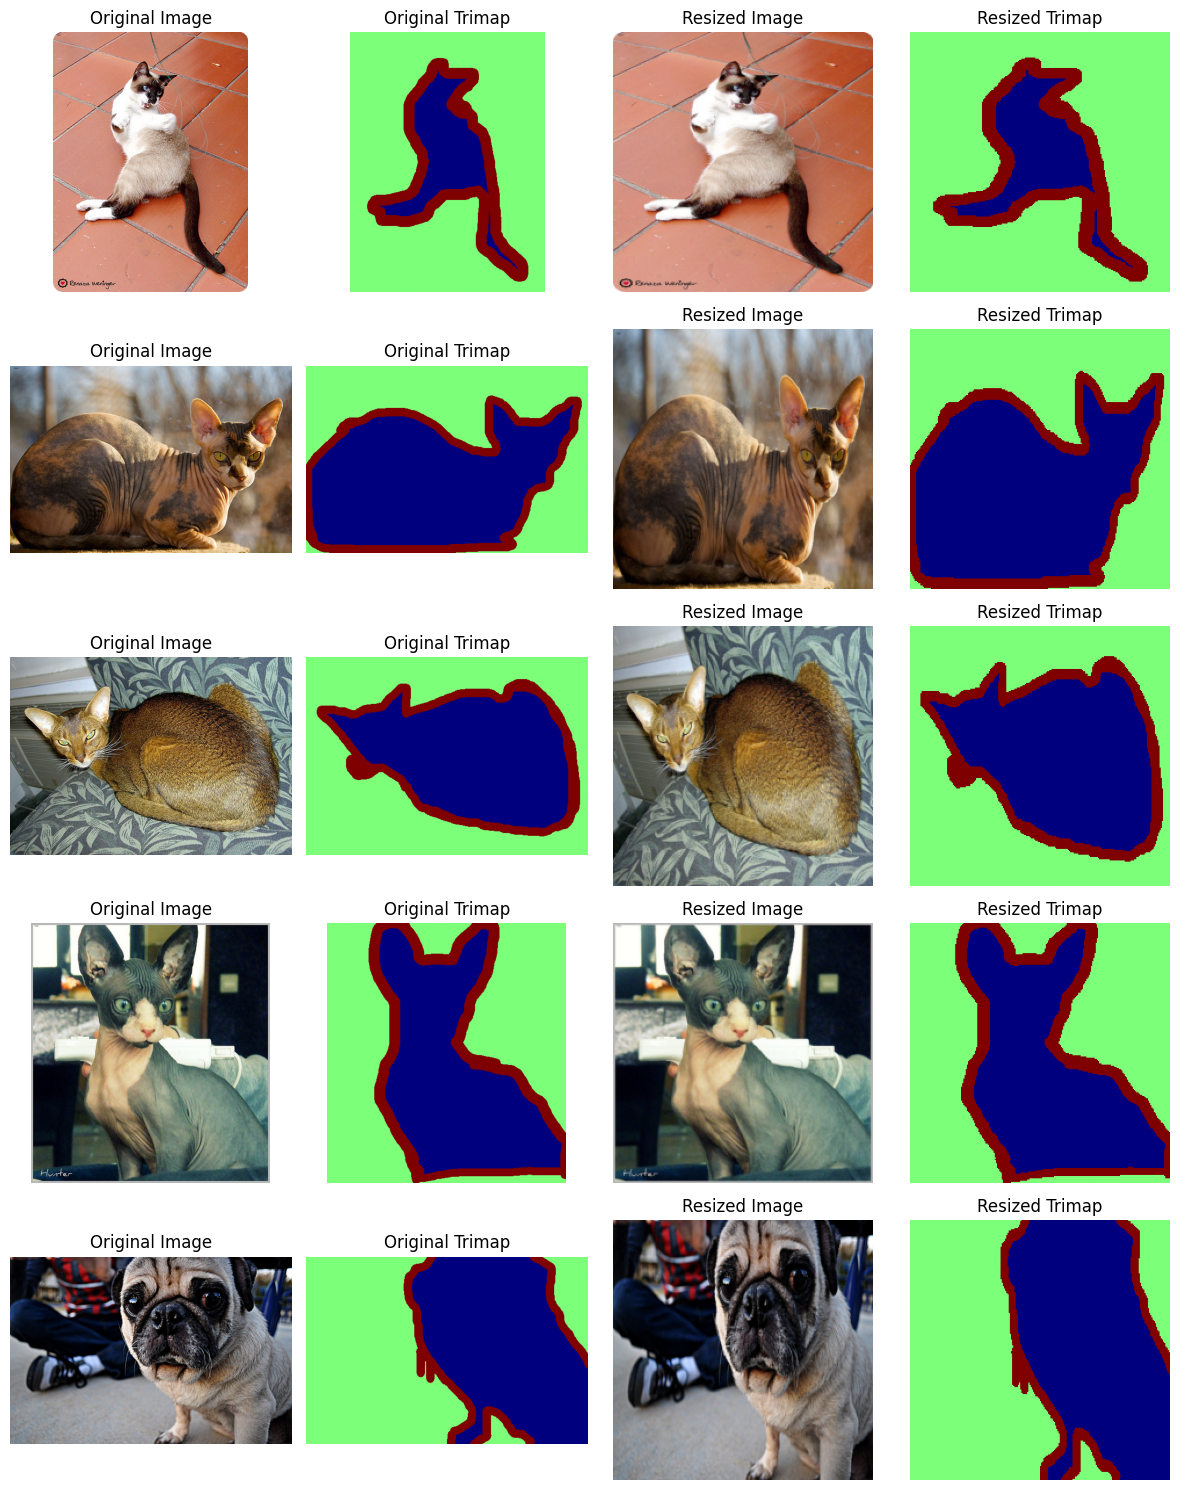

In [29]:
# Get the directory of the current script file
try:
    base_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # __file__ is not defined (e.g. in Jupyter notebook or interactive sessions apparently), fallback to cwd
    base_dir = os.getcwd()

# Suppose your dataset is in a folder named 'data' inside the project root:
data_dir = os.path.join(base_dir, 'data_oxford_iiit')

# # Then you can define image and trimap paths relative to that
image_folder = os.path.join(data_dir, 'images')
trimap_folder = os.path.join(data_dir, 'annotations\\trimaps')

# plot some images:
plot_original_and_resized(image_folder, trimap_folder, num_samples=5)

### Seems good. It seems that we can use the reshaped versions for image segmentation task. DO NOT FORGET to add this reshaping process in your final report.

I am not quite sure if the number of images we have enough for fine-tuning purpose. If not, then we can always perform data augmentation tricks.

## Next task: Define a trainer class

   ```
        ###
        # Note: self.dataloaders['train'], self.dataloaders['val']

        ###
        for i in range(self.num_epoch):
        
            # TRAIN STEP:
            self.model.train() # training model
            loss_ith_epoch_minibatch_cummul = 0.0
            num_minibatches_train = 0

            for minibatch_input, truth in self.dataloaders['train']:
                # Move data to device
                minibatch_input, truth = minibatch_input.to(self.device), truth.to(self.device)
                
                # Zero gradients
                self.optimizer.zero_grad()
                
                # forward pass (below)
                output_minibatch = self.model(minibatch_input, other_args)
                
                # compute loss
                loss_ith_epoch_minibatch = self.criterion(output_minibatch, truth)
                num_minibatches_train+=1
                
                # Accumulate loss
                loss_ith_epoch_minibatch_cummul+=loss_ith_epoch_minibatch.item()

                #Backward pass
                loss_ith_epoch_minibatch.backward()

                #Optimizer step
                self.optimizer.step()

            avg_epoch_train_loss = loss_ith_epoch_minibatch_cummul/num_minibatches_train
            self.train_error_epoch_list.append(avg_epoch_train_loss)

            #VAL STEP:
            self.model.eval() # validation model
            loss_ith_epoch_minibatch_val_cummul = 0.0
            num_minibatches_val = 0

            # disable gradients
            with torch.no_grad():
            
                # minibatch wise forward pass
                for minibatch_input, truth in self.dataloaders['val']:
                
                    # move data to device
                    minibatch_input, truth = minibatch_input.to(self.device), truth.to(self.device)

                    # forward pass
                    output_val_minibatch, total_val_error_ith_epoch = self.model(minibatch_input, other_args)
                    
                    # compute loss
                    loss_val = self.criterion(output_val_minibatch, truth)

                    # accumulate loss
                    loss_ith_epoch_minibatch_val_cummul += loss_val.item()

                    num_minibatches_val+= 1
            
            avg_epoch_val_loss = loss_ith_epoch_minibatch_val_cummul / num_minibatches_val
            self.val_error_epoch_list.append(avg_epoch_val_loss)
        ```

In [ ]:
class trainer:
    def __init__(self, model, 
                optimizer,lr, 
                criterion, num_epoch,
                dataloaders, 
                scheduler=None,device='cuda',
                model_kwargs = None,
                criterion_kwargs= {"num_classes": 2, "epsilon": 1e-6}):
        
        self.model = model
        self.optimizer = optimizer
        self.lr = lr
        self.criterion = criterion
        self.criterion_kwargs= criterion_kwargs 
        self.num_epoch = num_epoch
        self.dataloaders = dataloaders
        self.scheduler = scheduler
        self.device = device
        self.model_kwargs = model_kwargs if model_kwargs is not None else {}
        
        # Calculate and store dataset sizes:
        self.dataset_sizes = {split: len(dataloader.dataset) for split, dataloader in dataloaders.items()}

        ## error terms:
        self.train_error_epoch_list = []
        self.val_error_epoch_list = []

        ## metrics lists:
        self.val_dice_epoch_list = []
        self.val_iou_epoch_list = []

    ## these are the train, train_epoch and val_epoch functions we need:
    def train(self):
        for _ in range(self.num_epoch):
            # train and validation step for i'th epoch
            avg_epoch_train_loss = self.train_epoch()
            avg_epoch_val_loss, avg_epoch_val_dice, avg_epoch_val_iou = self.val_epoch()# unpack all three values returned by val_epoch
            
            # accumulate losses
            self.train_error_epoch_list.append(avg_epoch_train_loss)
            self.val_error_epoch_list.append(avg_epoch_val_loss)

            # accumulate metrics
            self.val_dice_epoch_list.append(avg_epoch_val_dice)
            self.val_iou_epoch_list.append(avg_epoch_val_iou)

    def train_epoch(self):
        # training mode
        self.model.train()  
        # initialise cumulative loss
        loss_ith_epoch_minibatch_cummul = 0.0
        
        for minibatch_input, truth in self.dataloaders['train']:
            # move data to device
            minibatch_input, truth = minibatch_input.to(self.device), truth.to(self.device)
            # zero gradients
            self.optimizer.zero_grad()
            # forward pass
            output_minibatch = self.model(minibatch_input, **self.model_kwargs)
            # calculate loss
            loss_ith_epoch_minibatch = self.criterion(output_minibatch, truth, **self.criterion_kwargs)
            # backward pass
            loss_ith_epoch_minibatch.backward()
            # optimizer step
            self.optimizer.step()
            # accumulate the loss for average calculation later
            batch_size = minibatch_input.size(0)
            loss_ith_epoch_minibatch_cummul += loss_ith_epoch_minibatch.item() * batch_size

        # calculate average train loss for the epoch
        avg_epoch_train_loss = loss_ith_epoch_minibatch_cummul / self.dataset_sizes['train'] if self.dataset_sizes['train'] > 0 else 0 
        # return weighted average train epoch loss
        return avg_epoch_train_loss

    def val_epoch(self):
        # evaluation mode
        self.model.eval()  
        # initialise cumulative loss and num_minibatch counter
        loss_ith_epoch_minibatch_val_cummul = 0.0
        dice_cum = 0.0 # cumulative
        iou_cum = 0.0 # cumulative

        # no-grad mode
        with torch.no_grad():
            for minibatch_input, truth in self.dataloaders['val']:
                # move to device
                minibatch_input, truth = minibatch_input.to(self.device), truth.to(self.device)
                # forward pass
                output_val_minibatch = self.model(minibatch_input, **self.model_kwargs)

                # validation loss
                loss_val, dice_score, iou_score = self.criterion(output_val_minibatch, truth,
                                    **{**self.criterion_kwargs, "return_metrics": True})
                
                batch_size = minibatch_input.size(0)
                # accumulate loss for average caln later
                loss_ith_epoch_minibatch_val_cummul += loss_val.item() * batch_size
                # accumulate metrics
                dice_cum += dice_score.item() if isinstance(dice_score, torch.Tensor) else dice_score
                iou_cum += iou_score.item() if isinstance(iou_score, torch.Tensor) else iou_score

        # calculate average val loss for the epoch
        avg_epoch_val_loss = loss_ith_epoch_minibatch_val_cummul / self.dataset_sizes['val'] if self.dataset_sizes['val'] > 0 else 0
        # calculate average metrics
        avg_dice = dice_cum / self.dataset_sizes['val'] if self.dataset_sizes['val'] > 0 else 0
        avg_iou = iou_cum / self.dataset_sizes['val'] if self.dataset_sizes['val'] > 0 else 0

        return avg_epoch_val_loss, avg_dice, avg_iou # return average val epoch loss
        #return avg_epoch_val_loss 


    def test(self):
        pass

    def save_model(self):
        pass

    def load_model(self):
        pass

In [30]:
# run the experiment and get it moving :)

In [31]:
# more advanced adapter based method
# what are the other methods that we can have for this work